In [1]:
import json
import os

import tqdm
import datetime
import pytz
import numpy

import pandas

import scipy.stats

%matplotlib widget
import matplotlib
import matplotlib.pyplot

import seaborn

# General settings and experiment location

In [2]:
source_computer = 'sting'
REAGGLOMERATE_FLAG = False
RECALCULATION_FLAG = True
WR_CONFIDENCE       = 0.50
LIMIT_DATE_SETUP_START  = pytz.utc.localize(datetime.datetime(2023,6,30))
LIMIT_DATE_EXP          = pytz.utc.localize(datetime.datetime(2023,7,5))
LIMIT_DATE_SETUP_STOP   = pytz.utc.localize(datetime.datetime(2023,7,30))
root_path = '/Users/matthieu/.ssh/ssh_to_graz/saved_graz_data/' + source_computer + '/metadata/'
data_path = root_path + '/'
conf_path = root_path + '../config/'


days_to_discard_str = [] #['23/07/22', '23/07/25']#, '23/07/24', '23/07/26']
days_to_discard = [pytz.utc.localize(datetime.datetime.strptime(x, '%y/%m/%d')).date() for x in days_to_discard_str]

pfiles = sorted([f for f in os.listdir(data_path) if f.endswith('.pickle')])
# print(pfiles)

# Waggle runs gathering and cleaning

In [3]:
# Gather waggles
if REAGGLOMERATE_FLAG : 
    all_waggles_df = []
    for id_f, f in enumerate(pfiles) :
        if id_f == 0:
            all_waggles_df = pandas.read_pickle(data_path + f)
            continue

        meta_df = pandas.read_pickle(data_path + f)
        all_waggles_df = pandas.concat((all_waggles_df, meta_df), ignore_index=True)
    pandas.to_pickle(all_waggles_df, root_path+'all_waggles.pickle')
else :
    all_waggles_df = pandas.read_pickle(root_path+'all_waggles.pickle')

# Clean dataframe
all_waggles_df = all_waggles_df[~all_waggles_df.isnull().any(axis=1)]

# Comb config processing : experiments times

In [4]:
# load config file
with open(conf_path+'comb_config.json', "r") as f:
    exp_configuration = json.load(f)

exp_configs = [[]]*len(exp_configuration['experiment']['timeslots'])
for conf_id, conf in enumerate(exp_configuration['experiment']['timeslots']):
    exp_config = conf
    exp_config['dtts_start'] = datetime.datetime.fromisoformat(conf["from"])
    exp_config['dtts_stop'] = datetime.datetime.fromisoformat(conf["to"])
    exp_configs[conf_id] = exp_config

exp_configs = pandas.DataFrame.from_records(exp_configs).tail(-1) # remove first row --> default configuration

## Effect of the vibrations on the number of waggle runs for the 2 hours experiments : Processing

In [5]:
DURATION_EXPERIMENT_2H = datetime.timedelta(minutes=10.0)
results = []

for exp_i, exp in exp_configs.iterrows():
    # print(exp)
    res = dict(exp)

    if exp['dtts_start'] < LIMIT_DATE_SETUP_START or exp['dtts_start'] > LIMIT_DATE_EXP :
        continue

    if exp['dtts_start'].date() in days_to_discard :
        continue
    
    if exp.rule == 'vibrate':
        res['type'] = 'exp'
        ctrl_start_time = exp['dtts_start'] - DURATION_EXPERIMENT_2H
        ctrl_stop_time  = exp['dtts_start']
        vibs_start_time = exp['dtts_start']
        vibs_stop_time  = exp['dtts_start'] + DURATION_EXPERIMENT_2H
    elif exp.rule == 'no_vibrate':
        res['type'] = 'blank'
        ctrl_start_time = exp['dtts_start'] - DURATION_EXPERIMENT_2H
        ctrl_stop_time  = exp['dtts_start']
        vibs_start_time = exp['dtts_start']
        vibs_stop_time  = exp['dtts_start'] + DURATION_EXPERIMENT_2H
    

    # Naively take all of the waggles and count them
    ctrl_runs = all_waggles_df[all_waggles_df.timestamp_begin > ctrl_start_time]
    ctrl_runs = ctrl_runs[ctrl_runs.timestamp_begin < ctrl_stop_time]
    vibs_runs = all_waggles_df[all_waggles_df.timestamp_begin > vibs_start_time]
    vibs_runs = vibs_runs[vibs_runs.timestamp_begin < vibs_stop_time]

    res['Ncount_ctrl'] = len(ctrl_runs)
    res['Ncount_vibs'] = len(vibs_runs)
    
    # Take only the waggles with high confidence and count them
    ctrl_runs_confidence = ctrl_runs[ctrl_runs.label_confidence > WR_CONFIDENCE]
    vibs_runs_confidence = vibs_runs[vibs_runs.label_confidence > WR_CONFIDENCE]

    res['Ccount_ctrl'] = len(ctrl_runs_confidence)
    res['Ccount_vibs'] = len(vibs_runs_confidence)

    # Compare waggle runs that we want to inhibit with others
    target_angle            = exp.angle_deg
    ctrl_runs_not_targeted  = ctrl_runs_confidence[abs(ctrl_runs_confidence.dance_world_angle_deg%360-target_angle) > 90]
    ctrl_runs_targeted      = ctrl_runs_confidence[abs(ctrl_runs_confidence.dance_world_angle_deg%360-target_angle) < 90]
    vibs_runs_not_targeted  = vibs_runs_confidence[abs((vibs_runs_confidence.dance_world_angle_deg)%360-target_angle) > 90]
    vibs_runs_targeted      = vibs_runs_confidence[abs((vibs_runs_confidence.dance_world_angle_deg)%360-target_angle) < 90]

    res['Tcount_ctrl']  = len(ctrl_runs_targeted)
    res['NTcount_ctrl'] = len(ctrl_runs_not_targeted)
    res['Tcount_vibs']  = len(vibs_runs_targeted)
    res['NTcount_vibs'] = len(vibs_runs_not_targeted)

    # if exp_i == 10:
    #     print(target_angle)
    #     print(vibs_runs_targeted.dance_world_angle_deg%360)

    results.append(res)

results_2h             = pandas.DataFrame.from_dict(results)
results_2h['drop_C']   = (results_2h.Ccount_ctrl-results_2h.Ccount_vibs)/results_2h.Ccount_ctrl
results_2h['drop_T']   = (results_2h.Tcount_ctrl-results_2h.Tcount_vibs)/results_2h.Tcount_ctrl
results_2h['drop_NT']  = (results_2h.NTcount_ctrl-results_2h.NTcount_vibs)/results_2h.NTcount_ctrl
results_2h

,from,to,rule,dtts_start,dtts_stop,current_sound_index,angle_deg,current_soundboard_index,type,Ncount_ctrl,Ncount_vibs,Ccount_ctrl,Ccount_vibs,Tcount_ctrl,NTcount_ctrl,Tcount_vibs,NTcount_vibs,drop_C,drop_T,drop_NT
0,2023-06-30T09:00:00+02:00,2023-06-30T09:10:00+02:00,vibrate,2023-06-30 09:00:00+02:00,2023-06-30 09:10:00+02:00,NaN,90.0,NaN,exp,256,98,249,98,233,16,91,7,0.606426,0.609442,0.562500
1,2023-06-30T09:40:00+02:00,2023-06-30T09:50:00+02:00,no_vibrate,2023-06-30 09:40:00+02:00,2023-06-30 09:50:00+02:00,NaN,90.0,NaN,blank,425,163,421,163,392,29,155,8,0.612827,0.604592,0.724138
2,2023-06-30T10:20:00+02:00,2023-06-30T10:30:00+02:00,no_vibrate,2023-06-30 10:20:00+02:00,2023-06-30 10:30:00+02:00,NaN,90.0,NaN,blank,303,220,299,215,250,49,197,18,0.280936,0.212000,0.632653
3,2023-06-30T11:00:00+02:00,2023-06-30T11:10:00+02:00,vibrate,2023-06-30 11:00:00+02:00,2023-06-30 11:10:00+02:00,NaN,90.0,NaN,exp,305,81,303,81,266,37,71,10,0.732673,0.733083,0.729730
4,2023-06-30T11:40:00+02:00,2023-06-30T11:50:00+02:00,no_vibrate,2023-06-30 11:40:00+02:00,2023-06-30 11:50:00+02:00,NaN,90.0,NaN,blank,256,318,252,315,237,15,286,29,-0.250000,-0.206751,-0.933333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,2023-07-04T16:20:00+02:00,2023-07-04T16:30:00+02:00,no_vibrate,2023-07-04 16:20:00+02:00,2023-07-04 16:30:00+02:00,NaN,90.0,NaN,blank,52,107,52,106,18,34,84,22,-1.038462,-3.666667,0.352941
71,2023-07-04T17:00:00+02:00,2023-07-04T17:10:00+02:00,vibrate,2023-07-04 17:00:00+02:00,2023-07-04 17:10:00+02:00,NaN,90.0,NaN,exp,51,55,51,55,3,48,39,16,-0.078431,-12.000000,0.666667
72,2023-07-04T17:40:00+02:00,2023-07-04T17:50:00+02:00,no_vibrate,2023-07-04 17:40:00+02:00,2023-07-04 17:50:00+02:00,NaN,90.0,NaN,blank,21,13,21,13,11,10,0,13,0.380952,1.000000,-0.300000
73,2023-07-04T18:20:00+02:00,2023-07-04T18:30:00+02:00,vibrate,2023-07-04 18:20:00+02:00,2023-07-04 18:30:00+02:00,NaN,90.0,NaN,exp,0,0,0,0,0,0,0,0,NaN,NaN,NaN


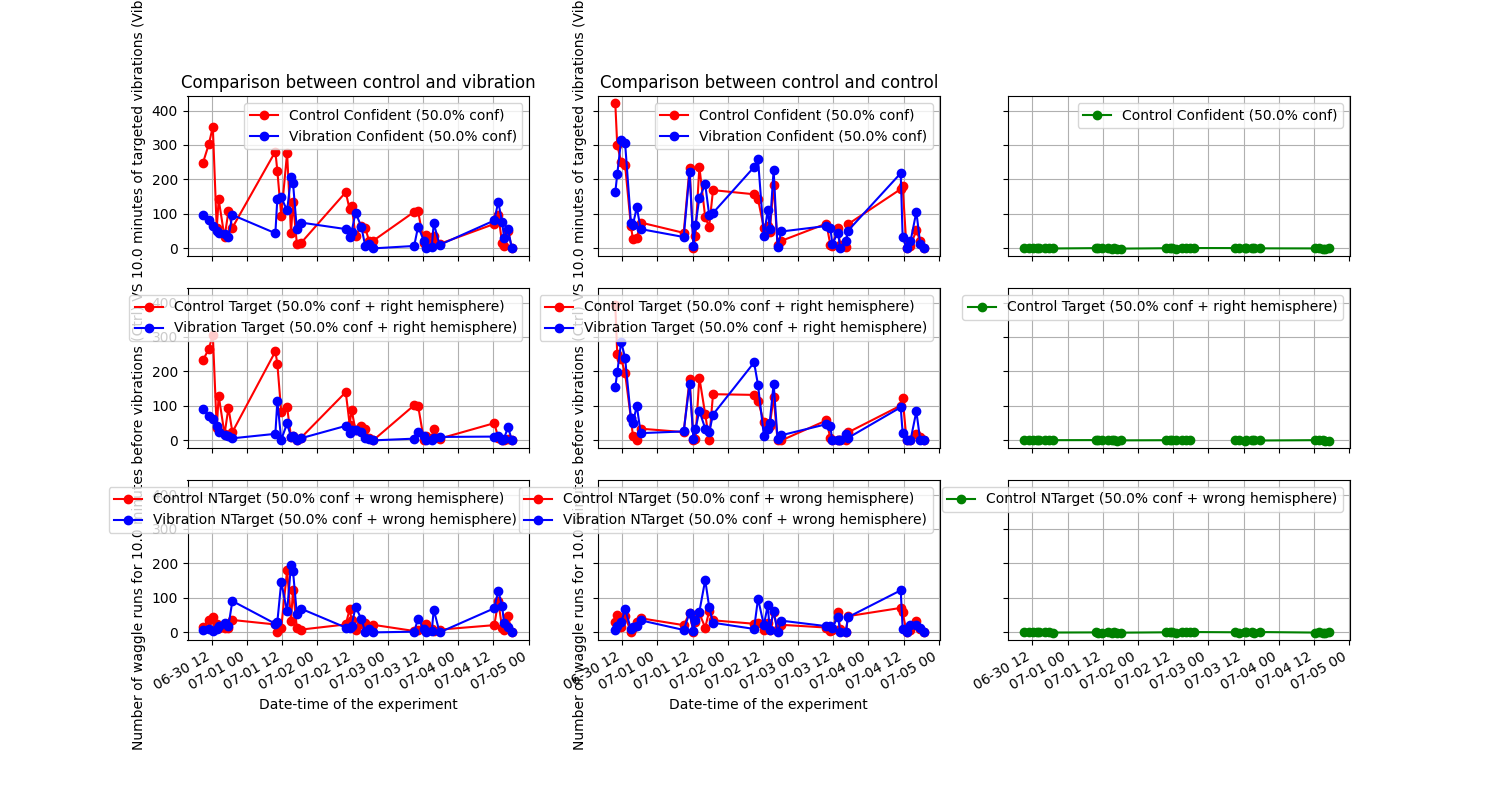

In [6]:
exp_results     = results_2h[results_2h.type == 'exp']
blank_results   = results_2h[results_2h.type == 'blank']

N_plots_h = 3
N_plots_v = 3
fig, ax = matplotlib.pyplot.subplots(N_plots_v, N_plots_h, figsize=(15,8), sharex=True, sharey=True)
ax[0,0].plot(exp_results.dtts_start, exp_results.Ccount_ctrl, c='r', marker='o', label='Control Confident ({}% conf)'.format(WR_CONFIDENCE*100))
ax[0,0].plot(exp_results.dtts_start, exp_results.Ccount_vibs, c='b', marker='o',label='Vibration Confident ({}% conf)'.format(WR_CONFIDENCE*100))

ax[1,0].plot(exp_results.dtts_start, exp_results.Tcount_ctrl, c='r', marker='o',label='Control Target ({}% conf + right hemisphere)'.format(WR_CONFIDENCE*100))
ax[1,0].plot(exp_results.dtts_start, exp_results.Tcount_vibs, c='b', marker='o',label='Vibration Target ({}% conf + right hemisphere)'.format(WR_CONFIDENCE*100))

ax[2,0].plot(exp_results.dtts_start, exp_results.NTcount_ctrl, c='r', marker='o',label='Control NTarget ({}% conf + wrong hemisphere)'.format(WR_CONFIDENCE*100))
ax[2,0].plot(exp_results.dtts_start, exp_results.NTcount_vibs, c='b', marker='o',label='Vibration NTarget ({}% conf + wrong hemisphere)'.format(WR_CONFIDENCE*100))


ax[0,2].plot(exp_results.dtts_start, (exp_results.Ccount_ctrl-exp_results.Ccount_vibs)/(exp_results.Ccount_ctrl+exp_results.Ccount_vibs), c='g', marker='o',label='Control Confident ({}% conf)'.format(WR_CONFIDENCE*100))
ax[1,2].plot(exp_results.dtts_start, (exp_results.Tcount_ctrl-exp_results.Tcount_vibs)/(exp_results.Tcount_ctrl+exp_results.Tcount_vibs), c='g', marker='o',label='Control Target ({}% conf + right hemisphere)'.format(WR_CONFIDENCE*100))
ax[2,2].plot(exp_results.dtts_start, (exp_results.NTcount_ctrl-exp_results.NTcount_vibs)/(exp_results.NTcount_ctrl+exp_results.NTcount_vibs), c='g', marker='o',label='Control NTarget ({}% conf + wrong hemisphere)'.format(WR_CONFIDENCE*100))


ax[0,1].plot(blank_results.dtts_start, blank_results.Ccount_ctrl, c='r', marker='o',label='Control Confident ({}% conf)'.format(WR_CONFIDENCE*100))
ax[0,1].plot(blank_results.dtts_start, blank_results.Ccount_vibs, c='b', marker='o',label='Vibration Confident ({}% conf)'.format(WR_CONFIDENCE*100))

ax[1,1].plot(blank_results.dtts_start, blank_results.Tcount_ctrl, c='r', marker='o',label='Control Target ({}% conf + right hemisphere)'.format(WR_CONFIDENCE*100))
ax[1,1].plot(blank_results.dtts_start, blank_results.Tcount_vibs, c='b', marker='o',label='Vibration Target ({}% conf + right hemisphere)'.format(WR_CONFIDENCE*100))

ax[2,1].plot(blank_results.dtts_start, blank_results.NTcount_ctrl, c='r', marker='o',label='Control NTarget ({}% conf + wrong hemisphere)'.format(WR_CONFIDENCE*100))
ax[2,1].plot(blank_results.dtts_start, blank_results.NTcount_vibs, c='b', marker='o',label='Vibration NTarget ({}% conf + wrong hemisphere)'.format(WR_CONFIDENCE*100))


for i in range(N_plots_v):
    for j in range(N_plots_h):
        ax[i,j].grid()
        ax[i,j].legend()

_ = ax[0,0].set_title('Comparison between control and vibration')
_ = ax[1,0].set_ylabel('Number of waggle runs for {} minutes before vibrations (Ctrl) VS {} minutes of targeted vibrations (Vibs)'.format(DURATION_EXPERIMENT_2H.total_seconds()/60, DURATION_EXPERIMENT_2H.total_seconds()/60))
_ = ax[2,0].set_xlabel('Date-time of the experiment')

_ = ax[0,1].set_title('Comparison between control and control')
_ = ax[1,1].set_ylabel('Number of waggle runs for {} minutes before vibrations (Ctrl) VS {} minutes of targeted vibrations (Vibs)'.format(DURATION_EXPERIMENT_2H.total_seconds()/60, DURATION_EXPERIMENT_2H.total_seconds()/60))
_ = ax[2,1].set_xlabel('Date-time of the experiment')

matplotlib.pyplot.gcf().autofmt_xdate()

Result of test for all waggle runs : RanksumsResult(statistic=1.9990564110984792, pvalue=0.04560225063808914)
Result of test for targeted waggle runs : RanksumsResult(statistic=2.828433779234703, pvalue=0.004677637734827855)
Result of test for NOT targeted waggle runs : RanksumsResult(statistic=0.16330319977987579, pvalue=0.8702797146632983)
Result of test for targeted waggle runs VS NOT targeted ones : RanksumsResult(statistic=2.1104505023220335, pvalue=0.034819570369993676)


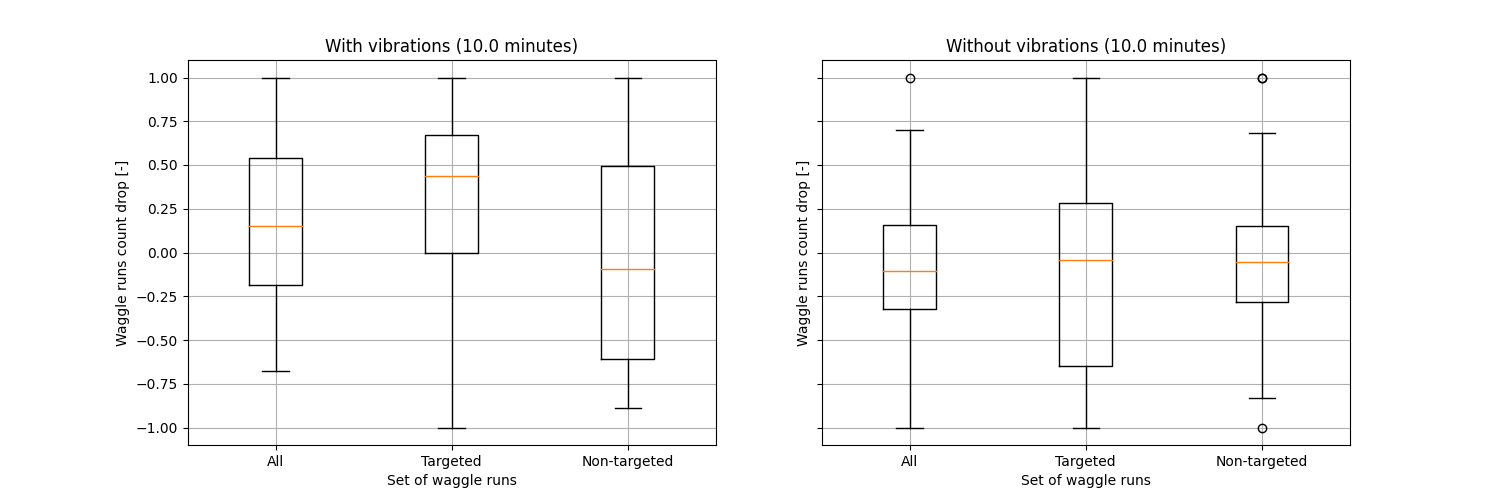

In [7]:
C_drop_exp  = (exp_results.Ccount_ctrl-exp_results.Ccount_vibs)/(exp_results.Ccount_ctrl+exp_results.Ccount_vibs)
NT_drop_exp = (exp_results.NTcount_ctrl-exp_results.NTcount_vibs)/(exp_results.NTcount_ctrl+exp_results.NTcount_vibs)
T_drop_exp  = (exp_results.Tcount_ctrl-exp_results.Tcount_vibs)/(exp_results.Tcount_ctrl+exp_results.Tcount_vibs)

C_drop_exp_nanfree  = C_drop_exp.values[~numpy.isnan(C_drop_exp.values)]
NT_drop_exp_nanfree = NT_drop_exp.values[~numpy.isnan(NT_drop_exp.values)]
T_drop_exp_nanfree  = T_drop_exp.values[~numpy.isnan(T_drop_exp.values)]

C_drop_blank  = (blank_results.Ccount_ctrl-blank_results.Ccount_vibs)/(blank_results.Ccount_ctrl+blank_results.Ccount_vibs)
NT_drop_blank = (blank_results.NTcount_ctrl-blank_results.NTcount_vibs)/(blank_results.NTcount_ctrl+blank_results.NTcount_vibs)
T_drop_blank  = (blank_results.Tcount_ctrl-blank_results.Tcount_vibs)/(blank_results.Tcount_ctrl+blank_results.Tcount_vibs)

C_drop_blank_nanfree  = C_drop_blank.values[~numpy.isnan(C_drop_blank.values)]
NT_drop_blank_nanfree = NT_drop_blank.values[~numpy.isnan(NT_drop_blank.values)]
T_drop_blank_nanfree  = T_drop_blank.values[~numpy.isnan(T_drop_blank.values)]

fig, ax = matplotlib.pyplot.subplots(1, 2, figsize=(15,5), sharey=True)

ax[0].boxplot([C_drop_exp_nanfree, T_drop_exp_nanfree, NT_drop_exp_nanfree], labels=['All', 'Targeted', 'Non-targeted'])
ax[0].set_title('With vibrations ({} minutes)'.format(DURATION_EXPERIMENT_2H.total_seconds()/60))
ax[0].set_xlabel('Set of waggle runs')
ax[0].set_ylabel('Waggle runs count drop [-]')
ax[0].grid()

ax[1].boxplot([C_drop_blank_nanfree, T_drop_blank_nanfree, NT_drop_blank_nanfree], labels=['All', 'Targeted','Non-targeted'])
ax[1].set_title('Without vibrations ({} minutes)'.format(DURATION_EXPERIMENT_2H.total_seconds()/60))
ax[1].set_xlabel('Set of waggle runs')
ax[1].set_ylabel('Waggle runs count drop [-]')
ax[1].grid()

print("Result of test for all waggle runs : {}".format(scipy.stats.ranksums(C_drop_exp_nanfree, C_drop_blank_nanfree)))
print("Result of test for targeted waggle runs : {}".format(scipy.stats.ranksums(T_drop_exp_nanfree, T_drop_blank_nanfree)))
print("Result of test for NOT targeted waggle runs : {}".format(scipy.stats.ranksums(NT_drop_exp_nanfree, NT_drop_blank_nanfree)))
print("Result of test for targeted waggle runs VS NOT targeted ones : {}".format(scipy.stats.ranksums(T_drop_exp_nanfree, NT_drop_exp_nanfree)))

Result of test for all waggle runs : RanksumsResult(statistic=2.931763649279746, pvalue=0.003370431447397711)
Result of test for targeted waggle runs : RanksumsResult(statistic=3.188935899216566, pvalue=0.0014279753837313771)
Result of test for NOT targeted waggle runs : RanksumsResult(statistic=0.3086066999241838, pvalue=0.7576207236833965)
Result of test for targeted waggle runs VS NOT targeted ones : RanksumsResult(statistic=2.6190177636751844, pvalue=0.008818335537277854)


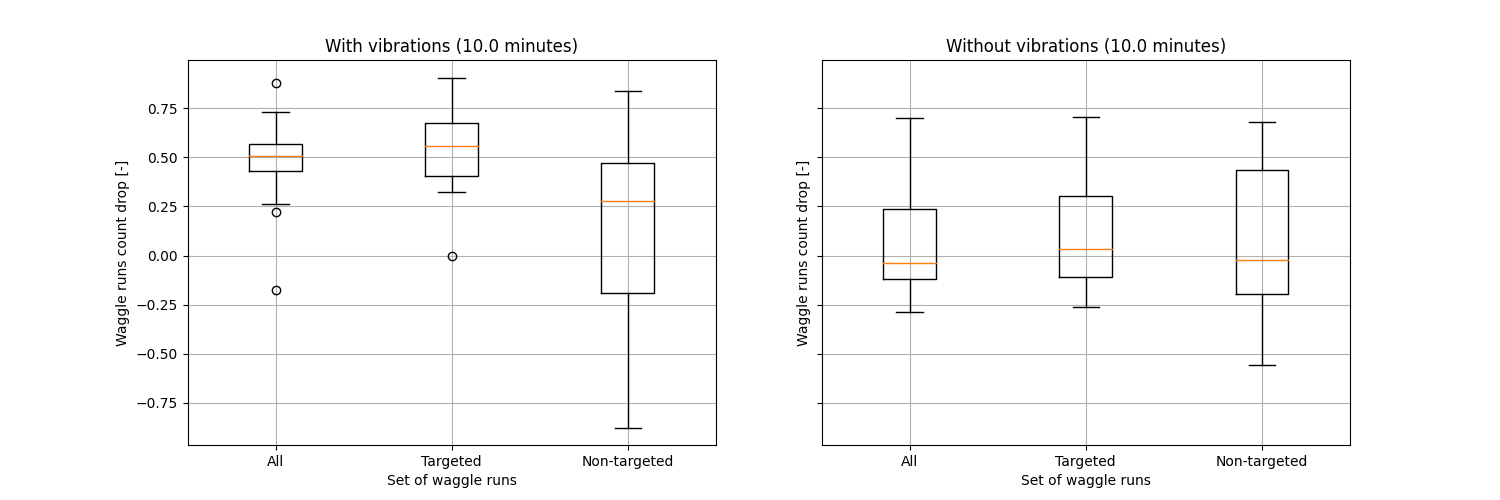

In [8]:
exp_results_conds = exp_results[exp_results.Ccount_ctrl < 500]
blank_results_conds = blank_results[blank_results.Ccount_ctrl < 500]

exp_results_conds = exp_results_conds[exp_results_conds.Ccount_ctrl > 100]
blank_results_conds = blank_results_conds[blank_results_conds.Ccount_ctrl > 100]

C_drop_exp  = (exp_results_conds.Ccount_ctrl-exp_results_conds.Ccount_vibs)/(exp_results_conds.Ccount_ctrl+exp_results_conds.Ccount_vibs)
NT_drop_exp = (exp_results_conds.NTcount_ctrl-exp_results_conds.NTcount_vibs)/(exp_results_conds.NTcount_ctrl+exp_results_conds.NTcount_vibs)
T_drop_exp  = (exp_results_conds.Tcount_ctrl-exp_results_conds.Tcount_vibs)/(exp_results_conds.Tcount_ctrl+exp_results_conds.Tcount_vibs)

C_drop_exp_nanfree  = C_drop_exp.values[~numpy.isnan(C_drop_exp.values)]
NT_drop_exp_nanfree = NT_drop_exp.values[~numpy.isnan(NT_drop_exp.values)]
T_drop_exp_nanfree  = T_drop_exp.values[~numpy.isnan(T_drop_exp.values)]

C_drop_blank  = (blank_results_conds.Ccount_ctrl-blank_results_conds.Ccount_vibs)/(blank_results_conds.Ccount_ctrl+blank_results_conds.Ccount_vibs)
NT_drop_blank = (blank_results_conds.NTcount_ctrl-blank_results_conds.NTcount_vibs)/(blank_results_conds.NTcount_ctrl+blank_results_conds.NTcount_vibs)
T_drop_blank  = (blank_results_conds.Tcount_ctrl-blank_results_conds.Tcount_vibs)/(blank_results_conds.Tcount_ctrl+blank_results_conds.Tcount_vibs)

C_drop_blank_nanfree  = C_drop_blank.values[~numpy.isnan(C_drop_blank.values)]
NT_drop_blank_nanfree = NT_drop_blank.values[~numpy.isnan(NT_drop_blank.values)]
T_drop_blank_nanfree  = T_drop_blank.values[~numpy.isnan(T_drop_blank.values)]

fig, ax = matplotlib.pyplot.subplots(1, 2, figsize=(15,5), sharey=True)

ax[0].boxplot([C_drop_exp_nanfree, T_drop_exp_nanfree, NT_drop_exp_nanfree], labels=['All', 'Targeted', 'Non-targeted'])
ax[0].set_title('With vibrations ({} minutes)'.format(DURATION_EXPERIMENT_2H.total_seconds()/60))
ax[0].set_xlabel('Set of waggle runs')
ax[0].set_ylabel('Waggle runs count drop [-]')
ax[0].grid()

ax[1].boxplot([C_drop_blank_nanfree, T_drop_blank_nanfree, NT_drop_blank_nanfree], labels=['All', 'Targeted','Non-targeted'])
ax[1].set_title('Without vibrations ({} minutes)'.format(DURATION_EXPERIMENT_2H.total_seconds()/60))
ax[1].set_xlabel('Set of waggle runs')
ax[1].set_ylabel('Waggle runs count drop [-]')
ax[1].grid()

# ax[2].hist(T_drop_blank_nanfree, bins=20, alpha=0.5, label='T')
# ax[3].hist(T_drop_exp_nanfree, bins=20, alpha=0.5, label='NT')
# ax[2].legend()
# ax[2].grid()
# ax[3].legend()
# ax[3].grid()

print("Result of test for all waggle runs : {}".format(scipy.stats.ranksums(C_drop_exp_nanfree, C_drop_blank_nanfree)))
print("Result of test for targeted waggle runs : {}".format(scipy.stats.ranksums(T_drop_exp_nanfree, T_drop_blank_nanfree)))
print("Result of test for NOT targeted waggle runs : {}".format(scipy.stats.ranksums(NT_drop_exp_nanfree, NT_drop_blank_nanfree)))
print("Result of test for targeted waggle runs VS NOT targeted ones : {}".format(scipy.stats.ranksums(T_drop_exp_nanfree, NT_drop_exp_nanfree)))

# Figures

In [9]:
import sklearn.svm
import math

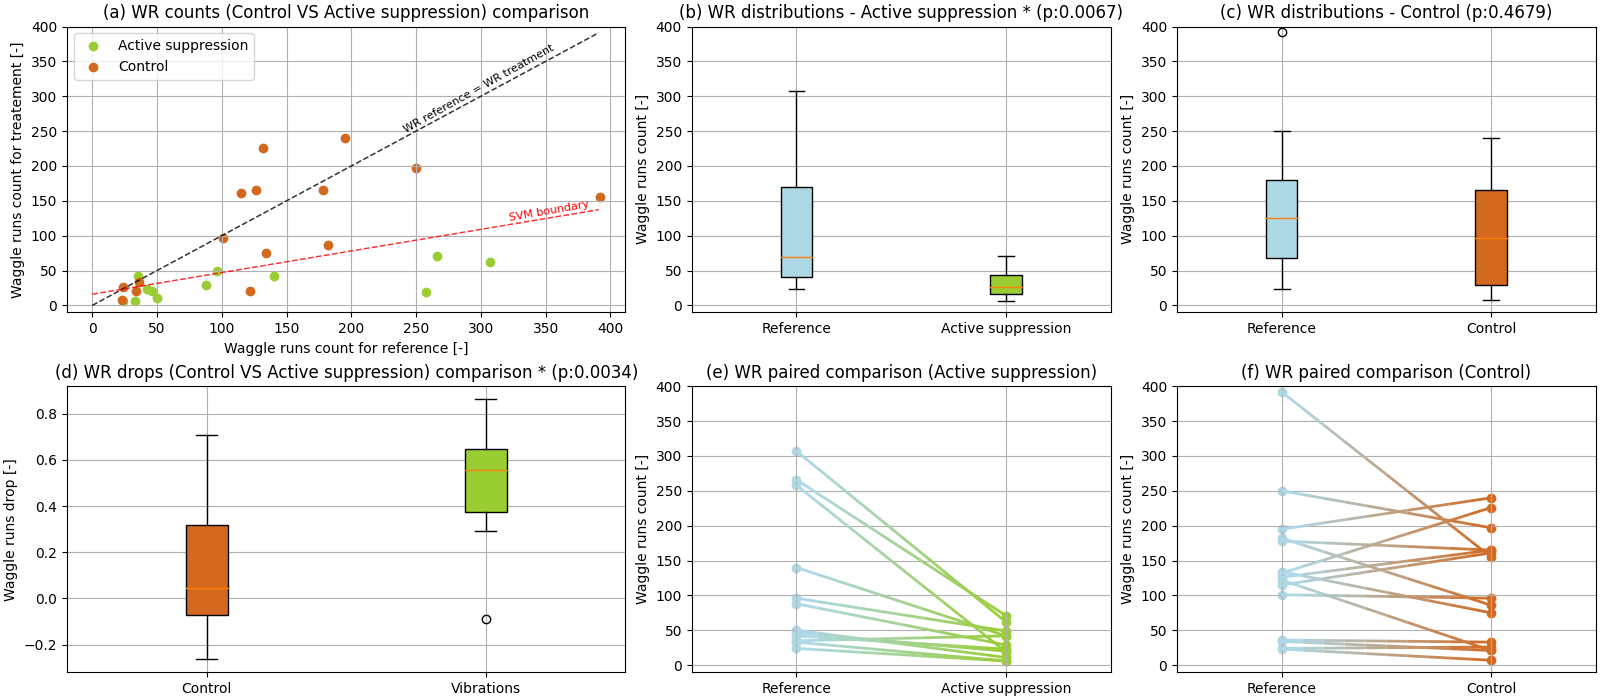

In [10]:
results_data = results_2h[results_2h.Ncount_ctrl > 30]
results_data = results_data[results_data.NTcount_ctrl > 20]
results_data = results_data[results_data.Tcount_ctrl > 20]

fig, ax = matplotlib.pyplot.subplots(2, 3, figsize=(16,7), height_ratios=[30, 30], width_ratios=[40, 30, 30], constrained_layout=True)

COLOR_REFERENCE = 'lightblue'
COLOR_CONTROL   = 'chocolate'
COLOR_VIBS      = 'yellowgreen'

x_y_line = range(max(results_data.Tcount_ctrl.max(), results_data.Tcount_vibs.max()))
text_location = numpy.array((x_y_line[-150], x_y_line[-150]))
trans_angle = ax[0,0].transData.transform_angles(numpy.array((45,)), text_location.reshape((1, 2)))[0]
_ = ax[0,0].plot(x_y_line, x_y_line, linestyle='dashed', c='k', linewidth=1.1, alpha=0.8)
_ = ax[0,0].text(text_location[0], text_location[1]+5, 'WR reference = WR treatment', fontsize=8, rotation=trans_angle, rotation_mode='anchor')

_ = ax[0,0].scatter(results_data[results_data.type == 'exp'].Tcount_ctrl, results_data[results_data.type == 'exp'].Tcount_vibs, c=COLOR_VIBS, label='Active suppression')
_ = ax[0,0].scatter(results_data[results_data.type == 'blank'].Tcount_ctrl, results_data[results_data.type == 'blank'].Tcount_vibs, c=COLOR_CONTROL, label='Control')

# SVM for separation
X = numpy.concatenate((numpy.expand_dims(results_data.Tcount_ctrl.values, axis=1), numpy.expand_dims(results_data.Tcount_vibs.values, axis=1)), axis=1)
y = results_data.type
svc_model = sklearn.svm.SVC(kernel='linear')
svc_model.fit(X, y)
slope = -svc_model.coef_[0,0]/svc_model.coef_[0,1]
inter = -svc_model.intercept_[0]/svc_model.coef_[0,1]
_ = ax[0,0].plot(x_y_line, numpy.array(x_y_line)*slope+inter, linestyle='dashed', c='r', linewidth=1.1, alpha=0.8)
text_location = numpy.array((x_y_line[-70], x_y_line[-70]*slope+inter))
trans_angle = ax[0,0].transData.transform_angles(numpy.array((math.atan(slope)*180/3.14,)), text_location.reshape((1, 2)))[0]
_ = ax[0,0].text(text_location[0], text_location[1]+5, 'SVM boundary', fontsize=8, rotation=trans_angle, rotation_mode='anchor', color='r')

bplot = ax[0,1].boxplot([results_data[results_data.type=='exp'].Tcount_ctrl, results_data[results_data.type=='exp'].Tcount_vibs], labels=['Reference', 'Active suppression'], patch_artist=True)
bplot['boxes'][0].set_facecolor(COLOR_REFERENCE)
bplot['boxes'][1].set_facecolor(COLOR_VIBS)
bplot = ax[0,2].boxplot([results_data[results_data.type=='blank'].Tcount_ctrl, results_data[results_data.type=='blank'].Tcount_vibs], labels=['Reference', 'Control'], patch_artist=True)
bplot['boxes'][0].set_facecolor(COLOR_REFERENCE)
bplot['boxes'][1].set_facecolor(COLOR_CONTROL)

distribution_dropT_vibs = (results_data[results_data.type=='exp'].Tcount_ctrl - results_data[results_data.type=='exp'].Tcount_vibs) / (results_data[results_data.type=='exp'].Tcount_ctrl + results_data[results_data.type=='exp'].Tcount_vibs)
distribution_dropT_ctrl = (results_data[results_data.type=='blank'].Tcount_ctrl - results_data[results_data.type=='blank'].Tcount_vibs) / (results_data[results_data.type=='blank'].Tcount_ctrl + results_data[results_data.type=='blank'].Tcount_vibs)
bplot = ax[1,0].boxplot([distribution_dropT_ctrl, distribution_dropT_vibs], labels=['Control', 'Vibrations'], patch_artist=True)
bplot['boxes'][0].set_facecolor(COLOR_CONTROL)
bplot['boxes'][1].set_facecolor(COLOR_VIBS)

# line plots
color_gradient      = matplotlib.pyplot.Normalize(0, 1)
COLORMAP_GRAD_VIBS  = matplotlib.colors.LinearSegmentedColormap.from_list("Custom", [COLOR_REFERENCE, COLOR_VIBS], N=30)
COLORMAP_GRAD_MOCK  = matplotlib.colors.LinearSegmentedColormap.from_list("Custom", [COLOR_REFERENCE, COLOR_CONTROL], N=30)
COLORMAP_GRAD_COMP  = matplotlib.colors.LinearSegmentedColormap.from_list("Custom", [COLOR_REFERENCE, COLOR_VIBS], N=30)

x_segments          = list(numpy.linspace(0, 1, 11))

points_vibs_wrs     = [numpy.array([[x, row.Tcount_ctrl + (-row.Tcount_ctrl+row.Tcount_vibs)*x] for x in x_segments]) for _, row in results_data[results_data.type=='exp'].iterrows()]
points_vibs_wrs     = [numpy.expand_dims(points_set, axis=1) for points_set in points_vibs_wrs]
segments_vibs_wrs   = [numpy.concatenate([points_set[:-1], points_set[1:]], axis=1) for points_set in list(points_vibs_wrs)]
lines               = [matplotlib.collections.LineCollection(segments_set, cmap=COLORMAP_GRAD_VIBS, norm=color_gradient) for segments_set in list(segments_vibs_wrs)]
_ = [lines_set.set_array(x_segments) for lines_set in lines]
_ = [lines_set.set_linewidth(2) for lines_set in lines]
line = [ax[1,1].add_collection(lines_set) for lines_set in lines]
ax[1,1].scatter([0]*len(results_data[results_data.type=='exp']), results_data[results_data.type=='exp'].Tcount_ctrl, color=COLOR_REFERENCE)
ax[1,1].scatter([1]*len(results_data[results_data.type=='exp']), results_data[results_data.type=='exp'].Tcount_vibs, color=COLOR_VIBS)

points_mock_wrs     = [numpy.array([[x, row.Tcount_ctrl + (-row.Tcount_ctrl+row.Tcount_vibs)*x] for x in x_segments]) for _, row in results_data[results_data.type=='blank'].iterrows()]
points_mock_wrs     = [numpy.expand_dims(points_set, axis=1) for points_set in points_mock_wrs]
segments_mock_wrs   = [numpy.concatenate([points_set[:-1], points_set[1:]], axis=1) for points_set in list(points_mock_wrs)]
lines               = [matplotlib.collections.LineCollection(segments_set, cmap=COLORMAP_GRAD_MOCK, norm=color_gradient) for segments_set in list(segments_mock_wrs)]
_ = [lines_set.set_array(x_segments) for lines_set in lines]
_ = [lines_set.set_linewidth(2) for lines_set in lines]
line = [ax[1,2].add_collection(lines_set) for lines_set in lines]
ax[1,2].scatter([0]*len(results_data[results_data.type=='blank']), results_data[results_data.type=='blank'].Tcount_ctrl, color=COLOR_REFERENCE)
ax[1,2].scatter([1]*len(results_data[results_data.type=='blank']), results_data[results_data.type=='blank'].Tcount_vibs, color=COLOR_CONTROL)


# Titles 
_ = ax[0,0].title.set_text('(a) WR counts (Control VS Active suppression) comparison')

RStest_exp = scipy.stats.ranksums(results_data[results_data.type=='exp'].Tcount_ctrl, results_data[results_data.type=='exp'].Tcount_vibs)
RStest_ctl = scipy.stats.ranksums(results_data[results_data.type=='blank'].Tcount_ctrl, results_data[results_data.type=='blank'].Tcount_vibs)
RStest_drop = scipy.stats.ranksums(distribution_dropT_ctrl, distribution_dropT_vibs)

_ = ax[0,1].title.set_text('(b) WR distributions - Active suppression * (p:{1:1.4f})'.format(RStest_exp[0], RStest_exp[1]))
_ = ax[0,2].title.set_text('(c) WR distributions - Control (p:{1:1.4f})'.format(RStest_ctl[0], RStest_ctl[1]))
_ = ax[1,0].title.set_text('(d) WR drops (Control VS Active suppression) comparison * (p:{1:1.4f})'.format(RStest_drop[0], RStest_drop[1]))

_ = ax[1,1].title.set_text('(e) WR paired comparison (Active suppression)')
_ = ax[1,2].title.set_text('(f) WR paired comparison (Control)')

# Axis names
_ = ax[0,0].set_xlabel('Waggle runs count for reference [-]')
_ = ax[0,0].set_ylabel('Waggle runs count for treatement [-]')

_ = ax[0,1].set_ylabel('Waggle runs count [-]')
_ = ax[0,2].set_ylabel('Waggle runs count [-]')
_ = ax[1,1].set_ylabel('Waggle runs count [-]')
_ = ax[1,2].set_ylabel('Waggle runs count [-]')
_ = ax[1,0].set_ylabel('Waggle runs drop [-]')

# ticks
_ = ax[1,1].set_xticks([0, 1])
_ = ax[1,1].set_xticklabels(['Reference', 'Active suppression'])
_ = ax[1,2].set_xticks([0, 1])
_ = ax[1,2].set_xticklabels(['Reference', 'Control'])

# Axis limits
YLIM_WR = [-10, 400]
_ = ax[0,0].set_ylim(YLIM_WR)
_ = ax[0,1].set_ylim(YLIM_WR)
_ = ax[0,2].set_ylim(YLIM_WR)
_ = ax[1,1].set_ylim(YLIM_WR)
_ = ax[1,2].set_ylim(YLIM_WR)

# _ = ax[0,0].set_aspect('equal')
XLIM_TYPE1 = [0.5, 2.5]
XLIM_TYPE2 = [-0.5, 1.5]
_ = ax[0,1].set_xlim(XLIM_TYPE1)
_ = ax[0,2].set_xlim(XLIM_TYPE1)
_ = ax[1,0].set_xlim(XLIM_TYPE1)
_ = ax[1,1].set_xlim(XLIM_TYPE2)
_ = ax[1,2].set_xlim(XLIM_TYPE2)

# Legends
_ = ax[0,0].legend(loc='upper left')

# Grids
_ = ax[0,0].grid()
_ = ax[1,0].grid()
_ = ax[0,1].grid()
_ = ax[0,2].grid()
_ = ax[1,1].grid()
_ = ax[1,2].grid()

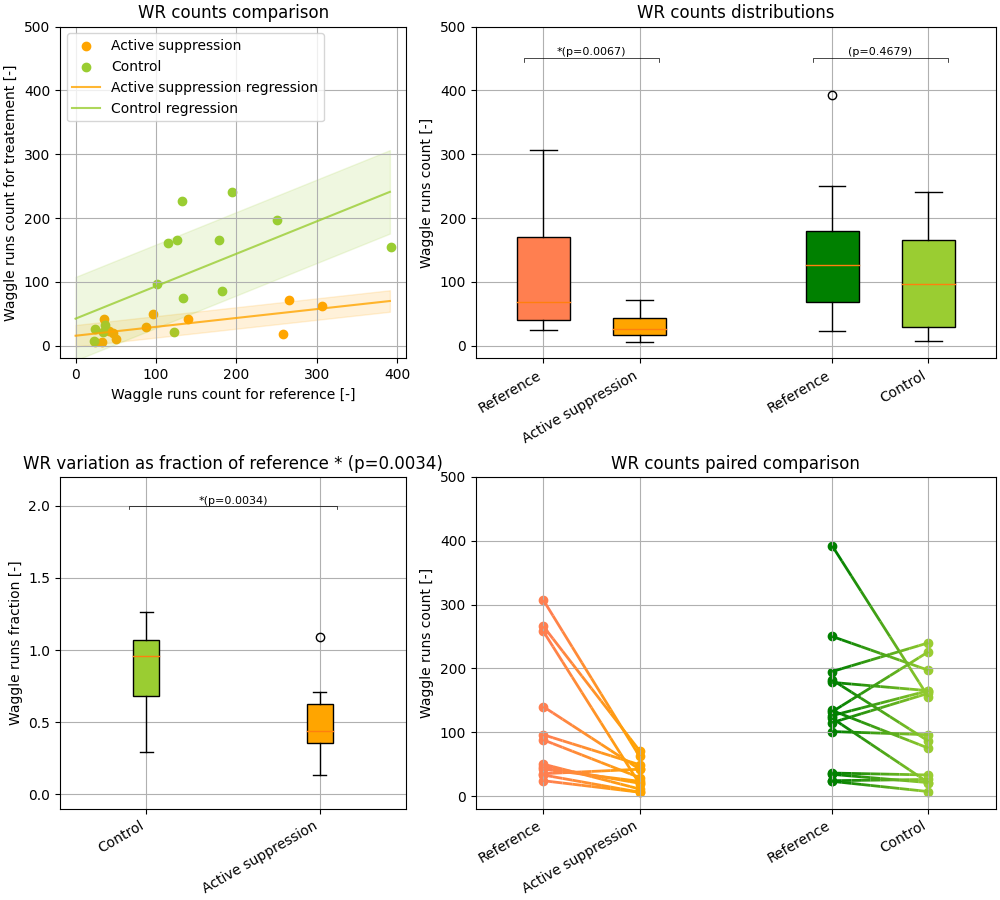

In [11]:
results_data = results_2h[results_2h.Ncount_ctrl > 30]
results_data = results_data[results_data.NTcount_ctrl > 20]
results_data = results_data[results_data.Tcount_ctrl > 20]

fig, ax = matplotlib.pyplot.subplots(2, 2, figsize=(10,9), height_ratios=[30, 30], width_ratios=[40, 60], constrained_layout=True)

COLOR_REFERENCE_CONTROL = 'green'
COLOR_CONTROL           = 'yellowgreen'
COLOR_REFERENCE_VIBS    = 'coral'
COLOR_VIBS              = 'orange'

_ = ax[0,0].scatter(results_data[results_data.type == 'exp'].Tcount_ctrl, results_data[results_data.type == 'exp'].Tcount_vibs, c=COLOR_VIBS, label='Active suppression')
_ = ax[0,0].scatter(results_data[results_data.type == 'blank'].Tcount_ctrl, results_data[results_data.type == 'blank'].Tcount_vibs, c=COLOR_CONTROL, label='Control')

# Regression lines
coeffs_exp, res_exp, _, _, _        = numpy.polyfit(results_data[results_data.type == 'exp'].Tcount_ctrl, results_data[results_data.type == 'exp'].Tcount_vibs, 1, full=True)
coeffs_blank, res_blank, _, _, _    = numpy.polyfit(results_data[results_data.type == 'blank'].Tcount_ctrl, results_data[results_data.type == 'blank'].Tcount_vibs, 1, full=True)
# source : chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://www.colorado.edu/amath/sites/default/files/attached-files/ch12_0.pdf
std_exp     = math.sqrt(res_exp/(len(results_data[results_data.type == 'exp'].Tcount_ctrl)-2))
std_blank   = math.sqrt(res_blank/(len(results_data[results_data.type == 'blank'].Tcount_ctrl)-2))
x_lines = range(max(results_data.Tcount_ctrl.max(), results_data.Tcount_vibs.max()))
y_exp   = coeffs_exp[0]*x_lines+coeffs_exp[1]
y_blank = coeffs_blank[0]*x_lines+coeffs_blank[1]
_ = ax[0,0].plot(x_lines, y_exp, c=COLOR_VIBS, label='Active suppression regression', alpha=0.8)
_ = ax[0,0].plot(x_lines, y_blank, c=COLOR_CONTROL, label='Control regression', alpha=0.8)
_ = ax[0,0].fill_between(x_lines, y_exp-std_exp, y_exp+std_exp, color=COLOR_VIBS, alpha=0.15)#, label='Active suppression STD regression')
_ = ax[0,0].fill_between(x_lines, y_blank-std_blank, y_blank+std_blank, color=COLOR_CONTROL, alpha=0.15)#, label='Control STD regression')

bplot = ax[0,1].boxplot([results_data[results_data.type=='exp'].Tcount_ctrl, results_data[results_data.type=='exp'].Tcount_vibs], positions=[1, 2], widths=[0.55, 0.55], labels=['Reference', 'Suppression'], patch_artist=True)
bplot['boxes'][0].set_facecolor(COLOR_REFERENCE_VIBS)
bplot['boxes'][1].set_facecolor(COLOR_VIBS)
bplot = ax[0,1].boxplot([results_data[results_data.type=='blank'].Tcount_ctrl, results_data[results_data.type=='blank'].Tcount_vibs], positions=[4, 5], widths=[0.55, 0.55], labels=['Reference', 'Control'], patch_artist=True)
bplot['boxes'][0].set_facecolor(COLOR_REFERENCE_CONTROL)
bplot['boxes'][1].set_facecolor(COLOR_CONTROL)

distribution_dropT_vibs = 1 - (results_data[results_data.type=='exp'].Tcount_ctrl - results_data[results_data.type=='exp'].Tcount_vibs) / (results_data[results_data.type=='exp'].Tcount_ctrl + results_data[results_data.type=='exp'].Tcount_vibs)
distribution_dropT_ctrl = 1 - (results_data[results_data.type=='blank'].Tcount_ctrl - results_data[results_data.type=='blank'].Tcount_vibs) / (results_data[results_data.type=='blank'].Tcount_ctrl + results_data[results_data.type=='blank'].Tcount_vibs)
bplot = ax[1,0].boxplot([distribution_dropT_ctrl, distribution_dropT_vibs], labels=['Control', 'Active suppression'], patch_artist=True)
bplot['boxes'][0].set_facecolor(COLOR_CONTROL)
bplot['boxes'][1].set_facecolor(COLOR_VIBS)

# line plots
color_gradient      = matplotlib.pyplot.Normalize(0, 1)
COLORMAP_GRAD_VIBS  = matplotlib.colors.LinearSegmentedColormap.from_list("Custom", [COLOR_REFERENCE_VIBS, COLOR_VIBS], N=30)
COLORMAP_GRAD_MOCK  = matplotlib.colors.LinearSegmentedColormap.from_list("Custom", [COLOR_REFERENCE_CONTROL, COLOR_CONTROL], N=30)
COLORMAP_GRAD_COMP  = matplotlib.colors.LinearSegmentedColormap.from_list("Custom", [COLOR_REFERENCE_VIBS, COLOR_VIBS], N=30)

x_segments          = list(numpy.linspace(0, 1, 11))

points_vibs_wrs     = [numpy.array([[x+1, row.Tcount_ctrl + (-row.Tcount_ctrl+row.Tcount_vibs)*x] for x in x_segments]) for _, row in results_data[results_data.type=='exp'].iterrows()]
points_vibs_wrs     = [numpy.expand_dims(points_set, axis=1) for points_set in points_vibs_wrs]
segments_vibs_wrs   = [numpy.concatenate([points_set[:-1], points_set[1:]], axis=1) for points_set in list(points_vibs_wrs)]
lines               = [matplotlib.collections.LineCollection(segments_set, cmap=COLORMAP_GRAD_VIBS, norm=color_gradient) for segments_set in list(segments_vibs_wrs)]
_ = [lines_set.set_array(x_segments) for lines_set in lines]
_ = [lines_set.set_linewidth(2) for lines_set in lines]
line = [ax[1,1].add_collection(lines_set) for lines_set in lines]
ax[1,1].scatter([1]*len(results_data[results_data.type=='exp']), results_data[results_data.type=='exp'].Tcount_ctrl, color=COLOR_REFERENCE_VIBS)
ax[1,1].scatter([2]*len(results_data[results_data.type=='exp']), results_data[results_data.type=='exp'].Tcount_vibs, color=COLOR_VIBS)

points_mock_wrs     = [numpy.array([[x+4, row.Tcount_ctrl + (-row.Tcount_ctrl+row.Tcount_vibs)*x] for x in x_segments]) for _, row in results_data[results_data.type=='blank'].iterrows()]
points_mock_wrs     = [numpy.expand_dims(points_set, axis=1) for points_set in points_mock_wrs]
segments_mock_wrs   = [numpy.concatenate([points_set[:-1], points_set[1:]], axis=1) for points_set in list(points_mock_wrs)]
lines               = [matplotlib.collections.LineCollection(segments_set, cmap=COLORMAP_GRAD_MOCK, norm=color_gradient) for segments_set in list(segments_mock_wrs)]
_ = [lines_set.set_array(x_segments) for lines_set in lines]
_ = [lines_set.set_linewidth(2) for lines_set in lines]
line = [ax[1,1].add_collection(lines_set) for lines_set in lines]
ax[1,1].scatter([4]*len(results_data[results_data.type=='blank']), results_data[results_data.type=='blank'].Tcount_ctrl, color=COLOR_REFERENCE_CONTROL)
ax[1,1].scatter([5]*len(results_data[results_data.type=='blank']), results_data[results_data.type=='blank'].Tcount_vibs, color=COLOR_CONTROL)


# Titles 
_ = ax[0,0].title.set_text('WR counts comparison')

RStest_exp = scipy.stats.ranksums(results_data[results_data.type=='exp'].Tcount_ctrl, results_data[results_data.type=='exp'].Tcount_vibs)
RStest_ctl = scipy.stats.ranksums(results_data[results_data.type=='blank'].Tcount_ctrl, results_data[results_data.type=='blank'].Tcount_vibs)
RStest_drop = scipy.stats.ranksums(distribution_dropT_ctrl, distribution_dropT_vibs)

_ = ax[0,1].title.set_text('WR counts distributions')
_ = ax[1,0].title.set_text('WR variation as fraction of reference * (p={:1.4f})'.format(RStest_drop[1]))

_ = ax[1,1].title.set_text('WR counts paired comparison')

# Axis names
_ = ax[0,0].set_xlabel('Waggle runs count for reference [-]')
_ = ax[0,0].set_ylabel('Waggle runs count for treatement [-]')

_ = ax[0,1].set_ylabel('Waggle runs count [-]')
_ = ax[1,1].set_ylabel('Waggle runs count [-]')
_ = ax[1,0].set_ylabel('Waggle runs fraction [-]')

# ticks
_ = ax[1,1].set_xticks([1, 2, 4, 5])
_ = ax[1,1].set_xticklabels(['Reference', 'Active suppression', 'Reference', 'Control'], rotation=30, ha='right')
_ = ax[0,1].set_xticklabels(['Reference', 'Active suppression', 'Reference', 'Control'], rotation=30, ha='right')
_ = ax[1,0].set_xticklabels(['Control', 'Active suppression'], rotation=30, ha='right')

# Axis limits
YLIM_WR     = [-20, 500]
YLIM_VAR    = [-0.1, 2.2]
_ = ax[0,0].set_ylim(YLIM_WR)
_ = ax[0,1].set_ylim(YLIM_WR)
_ = ax[1,1].set_ylim(YLIM_WR)
_ = ax[1,0].set_ylim(YLIM_VAR)

# _ = ax[0,0].set_aspect('equal')
XLIM_TYPE1 = [0.3, 5.7]
XLIM_TYPE2 = [0.5, 2.5]
_ = ax[0,1].set_xlim(XLIM_TYPE1)
_ = ax[1,0].set_xlim(XLIM_TYPE2)
_ = ax[1,1].set_xlim(XLIM_TYPE1)

# Legends
_ = ax[0,0].legend(loc='upper left')

# Grids
_ = ax[0,0].grid()
_ = ax[1,0].grid()
_ = ax[0,1].grid()
_ = ax[1,1].grid()

# Significance bars
sb_level    = 450
sb_width    = 1.4
sb_height   = 5
sb_positions= [1.5, 4.5]
_ = ax[0,1].plot([sb_positions[0]-sb_width/2, sb_positions[0]-sb_width/2, sb_positions[0]+sb_width/2, sb_positions[0]+sb_width/2], [sb_level-sb_height, sb_level, sb_level, sb_level-sb_height], 'k', linewidth=.5)
_ = ax[0,1].plot([sb_positions[1]-sb_width/2, sb_positions[1]-sb_width/2, sb_positions[1]+sb_width/2, sb_positions[1]+sb_width/2], [sb_level-sb_height, sb_level, sb_level, sb_level-sb_height], 'k', linewidth=.5)
_ = ax[0,1].text(sb_positions[0], sb_level+6, '*(p={:1.4f})'.format(RStest_exp[1]), fontsize=8, horizontalalignment='center')
_ = ax[0,1].text(sb_positions[1], sb_level+6, '(p={:1.4f})'.format(RStest_ctl[1]), fontsize=8, horizontalalignment='center')


sb_level    = 2
sb_width    = 1.2
sb_height   = 0.02
sb_positions= [1.5]
_ = ax[1,0].plot([sb_positions[0]-sb_width/2, sb_positions[0]-sb_width/2, sb_positions[0]+sb_width/2, sb_positions[0]+sb_width/2], [sb_level-sb_height, sb_level, sb_level, sb_level-sb_height], 'k', linewidth=.5)
_ = ax[1,0].text(sb_positions[0], sb_level+0.015, '*(p={:1.4f})'.format(RStest_drop[1]), fontsize=8, horizontalalignment='center')

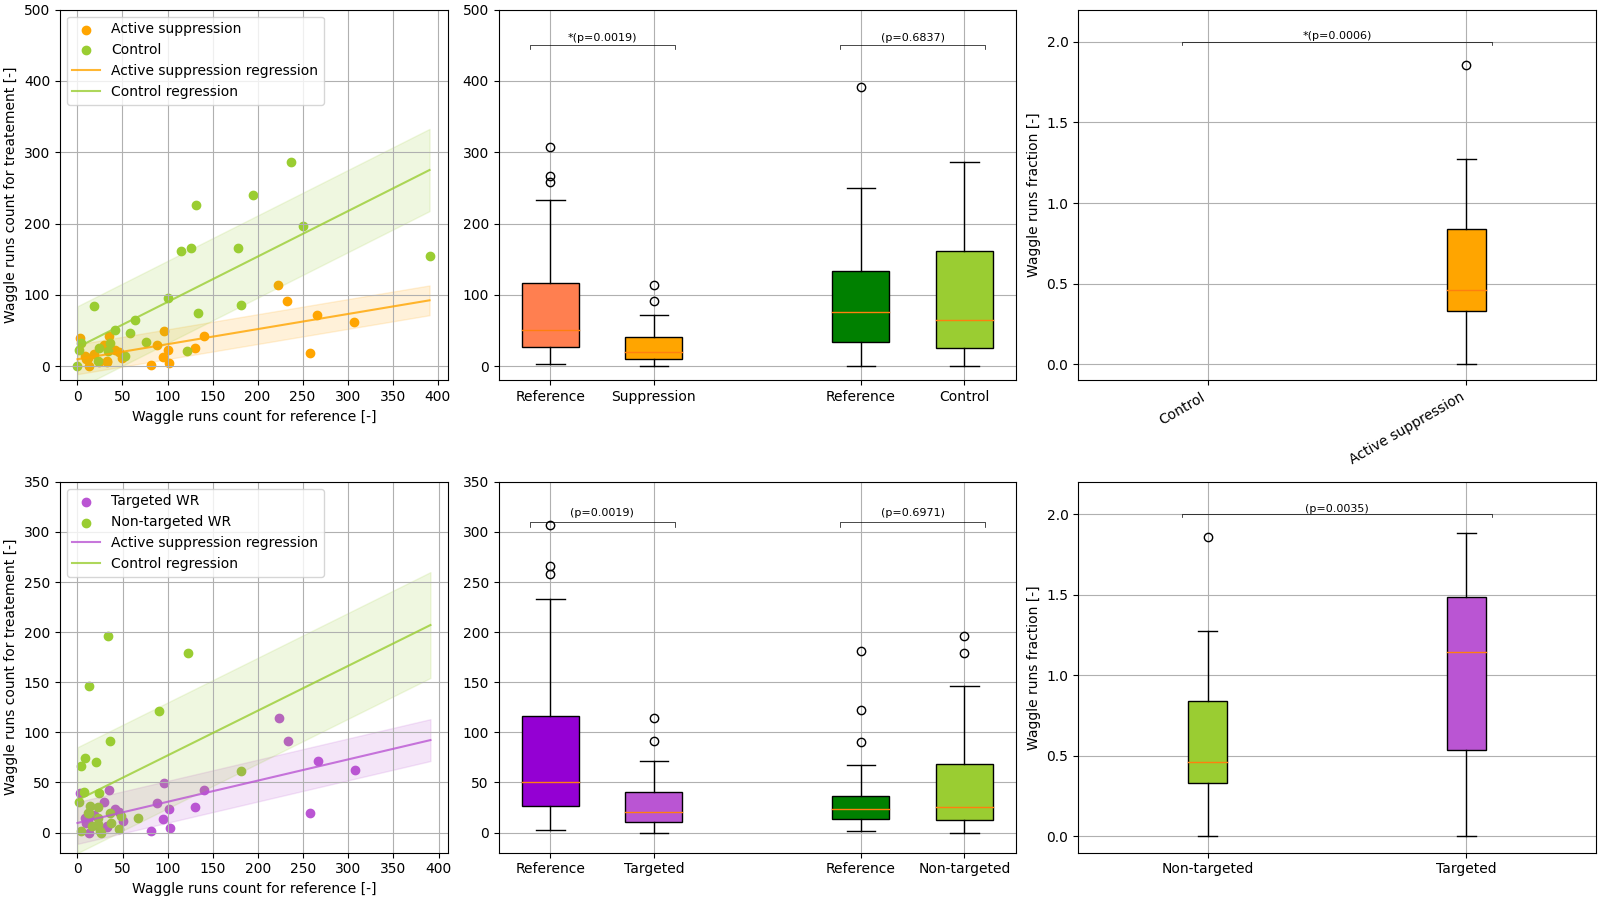

In [29]:
results_data = results_2h[results_2h.Ncount_ctrl > 30]

fig, ax = matplotlib.pyplot.subplots(2, 3, figsize=(16,9), height_ratios=[30, 30], width_ratios=[30, 40, 40], constrained_layout=True)

COLOR_REFERENCE_CONTROL = 'green'
COLOR_CONTROL           = 'yellowgreen'
COLOR_REFERENCE_VIBS    = 'coral'
COLOR_VIBS              = 'orange'

_ = ax[0,0].scatter(results_data[results_data.type == 'exp'].Tcount_ctrl, results_data[results_data.type == 'exp'].Tcount_vibs, c=COLOR_VIBS, label='Active suppression')
_ = ax[0,0].scatter(results_data[results_data.type == 'blank'].Tcount_ctrl, results_data[results_data.type == 'blank'].Tcount_vibs, c=COLOR_CONTROL, label='Control')

# Regression lines
coeffs_exp, res_exp, _, _, _        = numpy.polyfit(results_data[results_data.type == 'exp'].Tcount_ctrl, results_data[results_data.type == 'exp'].Tcount_vibs, 1, full=True)
coeffs_blank, res_blank, _, _, _    = numpy.polyfit(results_data[results_data.type == 'blank'].Tcount_ctrl, results_data[results_data.type == 'blank'].Tcount_vibs, 1, full=True)
# source : chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://www.colorado.edu/amath/sites/default/files/attached-files/ch12_0.pdf
std_exp     = math.sqrt(res_exp/(len(results_data[results_data.type == 'exp'].Tcount_ctrl)-2))
std_blank   = math.sqrt(res_blank/(len(results_data[results_data.type == 'blank'].Tcount_ctrl)-2))
x_lines = range(max(results_data.Tcount_ctrl.max(), results_data.Tcount_vibs.max()))
y_exp   = coeffs_exp[0]*x_lines+coeffs_exp[1]
y_blank = coeffs_blank[0]*x_lines+coeffs_blank[1]
_ = ax[0,0].plot(x_lines, y_exp, c=COLOR_VIBS, label='Active suppression regression', alpha=0.8)
_ = ax[0,0].plot(x_lines, y_blank, c=COLOR_CONTROL, label='Control regression', alpha=0.8)
_ = ax[0,0].fill_between(x_lines, y_exp-std_exp, y_exp+std_exp, color=COLOR_VIBS, alpha=0.15)#, label='Active suppression STD regression')
_ = ax[0,0].fill_between(x_lines, y_blank-std_blank, y_blank+std_blank, color=COLOR_CONTROL, alpha=0.15)#, label='Control STD regression')


bplot = ax[0,1].boxplot([results_data[results_data.type=='exp'].Tcount_ctrl, results_data[results_data.type=='exp'].Tcount_vibs], positions=[1, 2], widths=[0.55, 0.55], labels=['Reference', 'Suppression'], patch_artist=True)
bplot['boxes'][0].set_facecolor(COLOR_REFERENCE_VIBS)
bplot['boxes'][1].set_facecolor(COLOR_VIBS)
bplot = ax[0,1].boxplot([results_data[results_data.type=='blank'].Tcount_ctrl, results_data[results_data.type=='blank'].Tcount_vibs], positions=[4, 5], widths=[0.55, 0.55], labels=['Reference', 'Control'], patch_artist=True)
bplot['boxes'][0].set_facecolor(COLOR_REFERENCE_CONTROL)
bplot['boxes'][1].set_facecolor(COLOR_CONTROL)


distribution_dropT_vibs = 1 - (results_data[results_data.type=='exp'].Tcount_ctrl - results_data[results_data.type=='exp'].Tcount_vibs) / (results_data[results_data.type=='exp'].Tcount_ctrl + results_data[results_data.type=='exp'].Tcount_vibs)
distribution_dropT_ctrl = 1 - (results_data[results_data.type=='blank'].Tcount_ctrl - results_data[results_data.type=='blank'].Tcount_vibs) / (results_data[results_data.type=='blank'].Tcount_ctrl + results_data[results_data.type=='blank'].Tcount_vibs)
bplot = ax[0,2].boxplot([distribution_dropT_ctrl, distribution_dropT_vibs], labels=['Control', 'Active suppression'], patch_artist=True)
bplot['boxes'][0].set_facecolor(COLOR_CONTROL)
bplot['boxes'][1].set_facecolor(COLOR_VIBS)


COLOR_REFERENCE_NTARGET = 'green'
COLOR_NTARGET           = 'yellowgreen'
COLOR_REFERENCE_TARGET  = 'darkviolet'
COLOR_TARGET            = 'mediumorchid'

_ = ax[1,0].scatter(results_data[results_data.type == 'exp'].Tcount_ctrl, results_data[results_data.type == 'exp'].Tcount_vibs, c=COLOR_TARGET, label='Targeted WR')
_ = ax[1,0].scatter(results_data[results_data.type == 'exp'].NTcount_ctrl, results_data[results_data.type == 'exp'].NTcount_vibs, c=COLOR_NTARGET, label='Non-targeted WR')

# Regression lines
coeffs_exp, res_exp, _, _, _        = numpy.polyfit(results_data[results_data.type == 'exp'].Tcount_ctrl, results_data[results_data.type == 'exp'].Tcount_vibs, 1, full=True)
coeffs_blank, res_blank, _, _, _    = numpy.polyfit(results_data[results_data.type == 'exp'].NTcount_ctrl, results_data[results_data.type == 'exp'].NTcount_vibs, 1, full=True)
# source : chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://www.colorado.edu/amath/sites/default/files/attached-files/ch12_0.pdf
std_exp     = math.sqrt(res_exp/(len(results_data[results_data.type == 'exp'].Tcount_ctrl)-2))
std_blank   = math.sqrt(res_blank/(len(results_data[results_data.type == 'exp'].NTcount_ctrl)-2))
x_lines = range(max(results_data.Tcount_ctrl.max(), results_data.Tcount_vibs.max()))
y_exp   = coeffs_exp[0]*x_lines+coeffs_exp[1]
y_blank = coeffs_blank[0]*x_lines+coeffs_blank[1]
_ = ax[1,0].plot(x_lines, y_exp, c=COLOR_TARGET, label='Active suppression regression', alpha=0.8)
_ = ax[1,0].plot(x_lines, y_blank, c=COLOR_NTARGET, label='Control regression', alpha=0.8)
_ = ax[1,0].fill_between(x_lines, y_exp-std_exp, y_exp+std_exp, color=COLOR_TARGET, alpha=0.15)#, label='Active suppression STD regression')
_ = ax[1,0].fill_between(x_lines, y_blank-std_blank, y_blank+std_blank, color=COLOR_NTARGET, alpha=0.15)#, label='Control STD regression')

bplot = ax[1,1].boxplot([results_data[results_data.type=='exp'].Tcount_ctrl, results_data[results_data.type=='exp'].Tcount_vibs], positions=[1, 2], widths=[0.55, 0.55], labels=['Reference', 'Targeted'], patch_artist=True)
bplot['boxes'][0].set_facecolor(COLOR_REFERENCE_TARGET)
bplot['boxes'][1].set_facecolor(COLOR_TARGET)
bplot = ax[1,1].boxplot([results_data[results_data.type=='exp'].NTcount_ctrl, results_data[results_data.type=='exp'].NTcount_vibs], positions=[4, 5], widths=[0.55, 0.55], labels=['Reference', 'Non-targeted'], patch_artist=True)
bplot['boxes'][0].set_facecolor(COLOR_REFERENCE_NTARGET)
bplot['boxes'][1].set_facecolor(COLOR_NTARGET)


distribution_dropNT_vibs = 1 - (results_data[results_data.type=='exp'].NTcount_ctrl - results_data[results_data.type=='exp'].NTcount_vibs) / (results_data[results_data.type=='exp'].NTcount_ctrl + results_data[results_data.type=='exp'].NTcount_vibs)
bplot = ax[1,2].boxplot([distribution_dropT_vibs, distribution_dropNT_vibs], labels=['Non-targeted', 'Targeted'], patch_artist=True)
bplot['boxes'][0].set_facecolor(COLOR_NTARGET)
bplot['boxes'][1].set_facecolor(COLOR_TARGET)



# Titles
# _ = ax[0,0].title.set_text('')
# _ = ax[1,0].title.set_text('')
# _ = ax[0,1].title.set_text('')
# _ = ax[1,1].title.set_text('')
# _ = ax[0,2].title.set_text('')
# _ = ax[1,2].title.set_text('')

# Axis names
_ = ax[0,0].set_xlabel('Waggle runs count for reference [-]')
_ = ax[1,0].set_xlabel('Waggle runs count for reference [-]')
# _ = ax[0,1].set_xlabel('')
# _ = ax[1,1].set_xlabel('')
# _ = ax[0,2].set_xlabel('')
# _ = ax[1,2].set_xlabel('')

_ = ax[0,0].set_ylabel('Waggle runs count for treatement [-]')
_ = ax[1,0].set_ylabel('Waggle runs count for treatement [-]')
# _ = ax[0,1].set_ylabel('')
# _ = ax[1,1].set_ylabel('')
_ = ax[0,2].set_ylabel('Waggle runs fraction [-]')
_ = ax[1,2].set_ylabel('Waggle runs fraction [-]')

# ticks
_ = ax[0,2].set_xticklabels(['Control', 'Active suppression'], rotation=30, ha='right')

# Axis limits
YLIM_WR1    = [-20, 500]
YLIM_WR2    = [-20, 350]
YLIM_VAR    = [-0.1, 2.2]
_ = ax[0,0].set_ylim(YLIM_WR1)
_ = ax[1,0].set_ylim(YLIM_WR2)
_ = ax[0,1].set_ylim(YLIM_WR1)
_ = ax[1,1].set_ylim(YLIM_WR2)
_ = ax[0,2].set_ylim(YLIM_VAR)
_ = ax[1,2].set_ylim(YLIM_VAR)

# _ = ax[0,0].set_aspect('equal')
XLIM_TYPE1 = [0.3, 5.7]
XLIM_TYPE2 = [0.5, 2.5]
# _ = ax[0,0].set_xlim(XLIM_TYPE2)
# _ = ax[1,0].set_xlim(XLIM_TYPE2)
# _ = ax[0,1].set_xlim(XLIM_TYPE2)
# _ = ax[1,1].set_xlim(XLIM_TYPE2)
_ = ax[0,2].set_xlim(XLIM_TYPE2)
# _ = ax[1,2].set_xlim(XLIM_TYPE2)

# Legends
_ = ax[0,0].legend(loc='upper left')
_ = ax[1,0].legend(loc='upper left')

# Grids
_ = ax[0,0].grid()
_ = ax[1,0].grid()
_ = ax[0,1].grid()
_ = ax[1,1].grid()
_ = ax[0,2].grid()
_ = ax[1,2].grid()


# Tests WRS 
RStest_exp = scipy.stats.ranksums(results_data[results_data.type=='exp'].Tcount_ctrl, results_data[results_data.type=='exp'].Tcount_vibs)
RStest_ctl = scipy.stats.ranksums(results_data[results_data.type=='blank'].Tcount_ctrl, results_data[results_data.type=='blank'].Tcount_vibs)
RStest_drop = scipy.stats.ranksums(distribution_dropT_ctrl, distribution_dropT_vibs)

RStest_exp_target = scipy.stats.ranksums(results_data[results_data.type=='exp'].Tcount_ctrl, results_data[results_data.type=='exp'].Tcount_vibs)
RStest_exp_ntarget = scipy.stats.ranksums(results_data[results_data.type=='exp'].NTcount_ctrl, results_data[results_data.type=='exp'].NTcount_vibs)
RStest_drop_target = scipy.stats.ranksums(distribution_dropT_vibs, distribution_dropNT_vibs)

# Significance bars
sb_level    = 450
sb_width    = 1.4
sb_height   = 5
sb_positions= [1.5, 4.5]
_ = ax[0,1].plot([sb_positions[0]-sb_width/2, sb_positions[0]-sb_width/2, sb_positions[0]+sb_width/2, sb_positions[0]+sb_width/2], [sb_level-sb_height, sb_level, sb_level, sb_level-sb_height], 'k', linewidth=.5)
_ = ax[0,1].plot([sb_positions[1]-sb_width/2, sb_positions[1]-sb_width/2, sb_positions[1]+sb_width/2, sb_positions[1]+sb_width/2], [sb_level-sb_height, sb_level, sb_level, sb_level-sb_height], 'k', linewidth=.5)
_ = ax[0,1].text(sb_positions[0], sb_level+6, '*(p={:1.4f})'.format(RStest_exp[1]), fontsize=8, horizontalalignment='center')
_ = ax[0,1].text(sb_positions[1], sb_level+6, '(p={:1.4f})'.format(RStest_ctl[1]), fontsize=8, horizontalalignment='center')

sb_level    = 310
sb_width    = 1.4
sb_height   = 5
sb_positions= [1.5, 4.5]
_ = ax[1,1].plot([sb_positions[0]-sb_width/2, sb_positions[0]-sb_width/2, sb_positions[0]+sb_width/2, sb_positions[0]+sb_width/2], [sb_level-sb_height, sb_level, sb_level, sb_level-sb_height], 'k', linewidth=.5)
_ = ax[1,1].plot([sb_positions[1]-sb_width/2, sb_positions[1]-sb_width/2, sb_positions[1]+sb_width/2, sb_positions[1]+sb_width/2], [sb_level-sb_height, sb_level, sb_level, sb_level-sb_height], 'k', linewidth=.5)
_ = ax[1,1].text(sb_positions[0], sb_level+6, '(p={:1.4f})'.format(RStest_exp_target[1]), fontsize=8, horizontalalignment='center')
_ = ax[1,1].text(sb_positions[1], sb_level+6, '(p={:1.4f})'.format(RStest_exp_ntarget[1]), fontsize=8, horizontalalignment='center')

sb_level    = 2
sb_width    = 1.2
sb_height   = 0.02
sb_positions= [1.5]
_ = ax[0,2].plot([sb_positions[0]-sb_width/2, sb_positions[0]-sb_width/2, sb_positions[0]+sb_width/2, sb_positions[0]+sb_width/2], [sb_level-sb_height, sb_level, sb_level, sb_level-sb_height], 'k', linewidth=.5)
_ = ax[0,2].text(sb_positions[0], sb_level+0.015, '*(p={:1.4f})'.format(RStest_drop[1]), fontsize=8, horizontalalignment='center')


sb_level    = 2
sb_width    = 1.2
sb_height   = 0.02
sb_positions= [1.5]
_ = ax[1,2].plot([sb_positions[0]-sb_width/2, sb_positions[0]-sb_width/2, sb_positions[0]+sb_width/2, sb_positions[0]+sb_width/2], [sb_level-sb_height, sb_level, sb_level, sb_level-sb_height], 'k', linewidth=.5)
_ = ax[1,2].text(sb_positions[0], sb_level+0.015, '(p={:1.4f})'.format(RStest_drop_target[1]), fontsize=8, horizontalalignment='center')

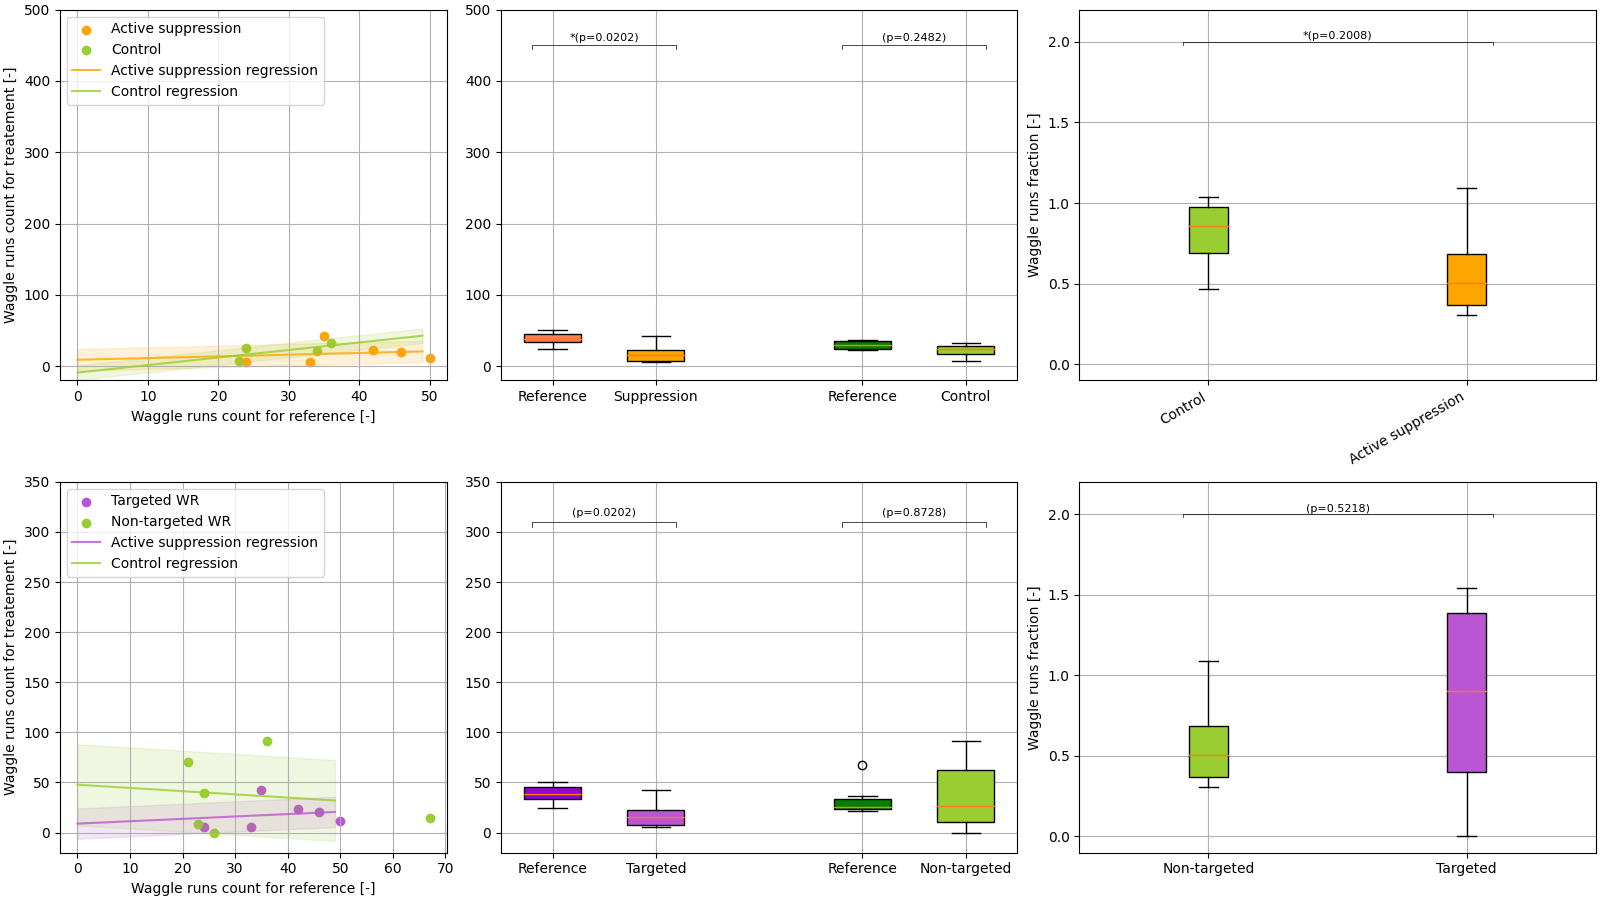

/Users/matthieu/.pyenv/versions/3.9.15/envs/default_conf/lib/python3.9/site-packages/ipympl/backend_nbagg.py:279: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  self.manager.handle_json(content)


In [25]:
results_data = results_2h[results_2h.Ncount_ctrl > 0]
results_data = results_data[results_data.NTcount_ctrl > 20]
results_data = results_data[results_data.Tcount_ctrl > 20]
results_data = results_data[results_data.Tcount_ctrl < 80]
# results_data = results_data[results_data.NTcount_ctrl < 100]

fig, ax = matplotlib.pyplot.subplots(2, 3, figsize=(16,9), height_ratios=[30, 30], width_ratios=[30, 40, 40], constrained_layout=True)

COLOR_REFERENCE_CONTROL = 'green'
COLOR_CONTROL           = 'yellowgreen'
COLOR_REFERENCE_VIBS    = 'coral'
COLOR_VIBS              = 'orange'

_ = ax[0,0].scatter(results_data[results_data.type == 'exp'].Tcount_ctrl, results_data[results_data.type == 'exp'].Tcount_vibs, c=COLOR_VIBS, label='Active suppression')
_ = ax[0,0].scatter(results_data[results_data.type == 'blank'].Tcount_ctrl, results_data[results_data.type == 'blank'].Tcount_vibs, c=COLOR_CONTROL, label='Control')

# Regression lines
coeffs_exp, res_exp, _, _, _        = numpy.polyfit(results_data[results_data.type == 'exp'].Tcount_ctrl, results_data[results_data.type == 'exp'].Tcount_vibs, 1, full=True)
coeffs_blank, res_blank, _, _, _    = numpy.polyfit(results_data[results_data.type == 'blank'].Tcount_ctrl, results_data[results_data.type == 'blank'].Tcount_vibs, 1, full=True)
# source : chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://www.colorado.edu/amath/sites/default/files/attached-files/ch12_0.pdf
std_exp     = math.sqrt(res_exp/(len(results_data[results_data.type == 'exp'].Tcount_ctrl)-2))
std_blank   = math.sqrt(res_blank/(len(results_data[results_data.type == 'blank'].Tcount_ctrl)-2))
x_lines = range(max(results_data.Tcount_ctrl.max(), results_data.Tcount_vibs.max()))
y_exp   = coeffs_exp[0]*x_lines+coeffs_exp[1]
y_blank = coeffs_blank[0]*x_lines+coeffs_blank[1]
_ = ax[0,0].plot(x_lines, y_exp, c=COLOR_VIBS, label='Active suppression regression', alpha=0.8)
_ = ax[0,0].plot(x_lines, y_blank, c=COLOR_CONTROL, label='Control regression', alpha=0.8)
_ = ax[0,0].fill_between(x_lines, y_exp-std_exp, y_exp+std_exp, color=COLOR_VIBS, alpha=0.15)#, label='Active suppression STD regression')
_ = ax[0,0].fill_between(x_lines, y_blank-std_blank, y_blank+std_blank, color=COLOR_CONTROL, alpha=0.15)#, label='Control STD regression')


bplot = ax[0,1].boxplot([results_data[results_data.type=='exp'].Tcount_ctrl, results_data[results_data.type=='exp'].Tcount_vibs], positions=[1, 2], widths=[0.55, 0.55], labels=['Reference', 'Suppression'], patch_artist=True)
bplot['boxes'][0].set_facecolor(COLOR_REFERENCE_VIBS)
bplot['boxes'][1].set_facecolor(COLOR_VIBS)
bplot = ax[0,1].boxplot([results_data[results_data.type=='blank'].Tcount_ctrl, results_data[results_data.type=='blank'].Tcount_vibs], positions=[4, 5], widths=[0.55, 0.55], labels=['Reference', 'Control'], patch_artist=True)
bplot['boxes'][0].set_facecolor(COLOR_REFERENCE_CONTROL)
bplot['boxes'][1].set_facecolor(COLOR_CONTROL)


distribution_dropT_vibs = 1 - (results_data[results_data.type=='exp'].Tcount_ctrl - results_data[results_data.type=='exp'].Tcount_vibs) / (results_data[results_data.type=='exp'].Tcount_ctrl + results_data[results_data.type=='exp'].Tcount_vibs)
distribution_dropT_ctrl = 1 - (results_data[results_data.type=='blank'].Tcount_ctrl - results_data[results_data.type=='blank'].Tcount_vibs) / (results_data[results_data.type=='blank'].Tcount_ctrl + results_data[results_data.type=='blank'].Tcount_vibs)
bplot = ax[0,2].boxplot([distribution_dropT_ctrl, distribution_dropT_vibs], labels=['Control', 'Active suppression'], patch_artist=True)
bplot['boxes'][0].set_facecolor(COLOR_CONTROL)
bplot['boxes'][1].set_facecolor(COLOR_VIBS)


COLOR_REFERENCE_NTARGET = 'green'
COLOR_NTARGET           = 'yellowgreen'
COLOR_REFERENCE_TARGET  = 'darkviolet'
COLOR_TARGET            = 'mediumorchid'

_ = ax[1,0].scatter(results_data[results_data.type == 'exp'].Tcount_ctrl, results_data[results_data.type == 'exp'].Tcount_vibs, c=COLOR_TARGET, label='Targeted WR')
_ = ax[1,0].scatter(results_data[results_data.type == 'exp'].NTcount_ctrl, results_data[results_data.type == 'exp'].NTcount_vibs, c=COLOR_NTARGET, label='Non-targeted WR')

# Regression lines
coeffs_exp, res_exp, _, _, _        = numpy.polyfit(results_data[results_data.type == 'exp'].Tcount_ctrl, results_data[results_data.type == 'exp'].Tcount_vibs, 1, full=True)
coeffs_blank, res_blank, _, _, _    = numpy.polyfit(results_data[results_data.type == 'exp'].NTcount_ctrl, results_data[results_data.type == 'exp'].NTcount_vibs, 1, full=True)
# source : chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://www.colorado.edu/amath/sites/default/files/attached-files/ch12_0.pdf
std_exp     = math.sqrt(res_exp/(len(results_data[results_data.type == 'exp'].Tcount_ctrl)-2))
std_blank   = math.sqrt(res_blank/(len(results_data[results_data.type == 'exp'].NTcount_ctrl)-2))
x_lines = range(max(results_data.Tcount_ctrl.max(), results_data.Tcount_vibs.max()))
y_exp   = coeffs_exp[0]*x_lines+coeffs_exp[1]
y_blank = coeffs_blank[0]*x_lines+coeffs_blank[1]
_ = ax[1,0].plot(x_lines, y_exp, c=COLOR_TARGET, label='Active suppression regression', alpha=0.8)
_ = ax[1,0].plot(x_lines, y_blank, c=COLOR_NTARGET, label='Control regression', alpha=0.8)
_ = ax[1,0].fill_between(x_lines, y_exp-std_exp, y_exp+std_exp, color=COLOR_TARGET, alpha=0.15)#, label='Active suppression STD regression')
_ = ax[1,0].fill_between(x_lines, y_blank-std_blank, y_blank+std_blank, color=COLOR_NTARGET, alpha=0.15)#, label='Control STD regression')

bplot = ax[1,1].boxplot([results_data[results_data.type=='exp'].Tcount_ctrl, results_data[results_data.type=='exp'].Tcount_vibs], positions=[1, 2], widths=[0.55, 0.55], labels=['Reference', 'Targeted'], patch_artist=True)
bplot['boxes'][0].set_facecolor(COLOR_REFERENCE_TARGET)
bplot['boxes'][1].set_facecolor(COLOR_TARGET)
bplot = ax[1,1].boxplot([results_data[results_data.type=='exp'].NTcount_ctrl, results_data[results_data.type=='exp'].NTcount_vibs], positions=[4, 5], widths=[0.55, 0.55], labels=['Reference', 'Non-targeted'], patch_artist=True)
bplot['boxes'][0].set_facecolor(COLOR_REFERENCE_NTARGET)
bplot['boxes'][1].set_facecolor(COLOR_NTARGET)


distribution_dropNT_vibs = 1 - (results_data[results_data.type=='exp'].NTcount_ctrl - results_data[results_data.type=='exp'].NTcount_vibs) / (results_data[results_data.type=='exp'].NTcount_ctrl + results_data[results_data.type=='exp'].NTcount_vibs)
bplot = ax[1,2].boxplot([distribution_dropT_vibs, distribution_dropNT_vibs], labels=['Non-targeted', 'Targeted'], patch_artist=True)
bplot['boxes'][0].set_facecolor(COLOR_NTARGET)
bplot['boxes'][1].set_facecolor(COLOR_TARGET)



# Titles
# _ = ax[0,0].title.set_text('')
# _ = ax[1,0].title.set_text('')
# _ = ax[0,1].title.set_text('')
# _ = ax[1,1].title.set_text('')
# _ = ax[0,2].title.set_text('')
# _ = ax[1,2].title.set_text('')

# Axis names
_ = ax[0,0].set_xlabel('Waggle runs count for reference [-]')
_ = ax[1,0].set_xlabel('Waggle runs count for reference [-]')
# _ = ax[0,1].set_xlabel('')
# _ = ax[1,1].set_xlabel('')
# _ = ax[0,2].set_xlabel('')
# _ = ax[1,2].set_xlabel('')

_ = ax[0,0].set_ylabel('Waggle runs count for treatement [-]')
_ = ax[1,0].set_ylabel('Waggle runs count for treatement [-]')
# _ = ax[0,1].set_ylabel('')
# _ = ax[1,1].set_ylabel('')
_ = ax[0,2].set_ylabel('Waggle runs fraction [-]')
_ = ax[1,2].set_ylabel('Waggle runs fraction [-]')

# ticks
_ = ax[0,2].set_xticklabels(['Control', 'Active suppression'], rotation=30, ha='right')

# Axis limits
YLIM_WR1    = [-20, 500]
YLIM_WR2    = [-20, 350]
YLIM_VAR    = [-0.1, 2.2]
_ = ax[0,0].set_ylim(YLIM_WR1)
_ = ax[1,0].set_ylim(YLIM_WR2)
_ = ax[0,1].set_ylim(YLIM_WR1)
_ = ax[1,1].set_ylim(YLIM_WR2)
_ = ax[0,2].set_ylim(YLIM_VAR)
_ = ax[1,2].set_ylim(YLIM_VAR)

# _ = ax[0,0].set_aspect('equal')
XLIM_TYPE1 = [0.3, 5.7]
XLIM_TYPE2 = [0.5, 2.5]
# _ = ax[0,0].set_xlim(XLIM_TYPE2)
# _ = ax[1,0].set_xlim(XLIM_TYPE2)
# _ = ax[0,1].set_xlim(XLIM_TYPE2)
# _ = ax[1,1].set_xlim(XLIM_TYPE2)
_ = ax[0,2].set_xlim(XLIM_TYPE2)
# _ = ax[1,2].set_xlim(XLIM_TYPE2)

# Legends
_ = ax[0,0].legend(loc='upper left')
_ = ax[1,0].legend(loc='upper left')

# Grids
_ = ax[0,0].grid()
_ = ax[1,0].grid()
_ = ax[0,1].grid()
_ = ax[1,1].grid()
_ = ax[0,2].grid()
_ = ax[1,2].grid()


# Tests WRS 
RStest_exp = scipy.stats.ranksums(results_data[results_data.type=='exp'].Tcount_ctrl, results_data[results_data.type=='exp'].Tcount_vibs)
RStest_ctl = scipy.stats.ranksums(results_data[results_data.type=='blank'].Tcount_ctrl, results_data[results_data.type=='blank'].Tcount_vibs)
RStest_drop = scipy.stats.ranksums(distribution_dropT_ctrl, distribution_dropT_vibs)

RStest_exp_target = scipy.stats.ranksums(results_data[results_data.type=='exp'].Tcount_ctrl, results_data[results_data.type=='exp'].Tcount_vibs)
RStest_exp_ntarget = scipy.stats.ranksums(results_data[results_data.type=='exp'].NTcount_ctrl, results_data[results_data.type=='exp'].NTcount_vibs)
RStest_drop_target = scipy.stats.ranksums(distribution_dropT_vibs, distribution_dropNT_vibs)

# Significance bars
sb_level    = 450
sb_width    = 1.4
sb_height   = 5
sb_positions= [1.5, 4.5]
_ = ax[0,1].plot([sb_positions[0]-sb_width/2, sb_positions[0]-sb_width/2, sb_positions[0]+sb_width/2, sb_positions[0]+sb_width/2], [sb_level-sb_height, sb_level, sb_level, sb_level-sb_height], 'k', linewidth=.5)
_ = ax[0,1].plot([sb_positions[1]-sb_width/2, sb_positions[1]-sb_width/2, sb_positions[1]+sb_width/2, sb_positions[1]+sb_width/2], [sb_level-sb_height, sb_level, sb_level, sb_level-sb_height], 'k', linewidth=.5)
_ = ax[0,1].text(sb_positions[0], sb_level+6, '*(p={:1.4f})'.format(RStest_exp[1]), fontsize=8, horizontalalignment='center')
_ = ax[0,1].text(sb_positions[1], sb_level+6, '(p={:1.4f})'.format(RStest_ctl[1]), fontsize=8, horizontalalignment='center')

sb_level    = 310
sb_width    = 1.4
sb_height   = 5
sb_positions= [1.5, 4.5]
_ = ax[1,1].plot([sb_positions[0]-sb_width/2, sb_positions[0]-sb_width/2, sb_positions[0]+sb_width/2, sb_positions[0]+sb_width/2], [sb_level-sb_height, sb_level, sb_level, sb_level-sb_height], 'k', linewidth=.5)
_ = ax[1,1].plot([sb_positions[1]-sb_width/2, sb_positions[1]-sb_width/2, sb_positions[1]+sb_width/2, sb_positions[1]+sb_width/2], [sb_level-sb_height, sb_level, sb_level, sb_level-sb_height], 'k', linewidth=.5)
_ = ax[1,1].text(sb_positions[0], sb_level+6, '(p={:1.4f})'.format(RStest_exp_target[1]), fontsize=8, horizontalalignment='center')
_ = ax[1,1].text(sb_positions[1], sb_level+6, '(p={:1.4f})'.format(RStest_exp_ntarget[1]), fontsize=8, horizontalalignment='center')

sb_level    = 2
sb_width    = 1.2
sb_height   = 0.02
sb_positions= [1.5]
_ = ax[0,2].plot([sb_positions[0]-sb_width/2, sb_positions[0]-sb_width/2, sb_positions[0]+sb_width/2, sb_positions[0]+sb_width/2], [sb_level-sb_height, sb_level, sb_level, sb_level-sb_height], 'k', linewidth=.5)
_ = ax[0,2].text(sb_positions[0], sb_level+0.015, '*(p={:1.4f})'.format(RStest_drop[1]), fontsize=8, horizontalalignment='center')


sb_level    = 2
sb_width    = 1.2
sb_height   = 0.02
sb_positions= [1.5]
_ = ax[1,2].plot([sb_positions[0]-sb_width/2, sb_positions[0]-sb_width/2, sb_positions[0]+sb_width/2, sb_positions[0]+sb_width/2], [sb_level-sb_height, sb_level, sb_level, sb_level-sb_height], 'k', linewidth=.5)
_ = ax[1,2].text(sb_positions[0], sb_level+0.015, '(p={:1.4f})'.format(RStest_drop_target[1]), fontsize=8, horizontalalignment='center')

In [27]:
print(scipy.stats.ranksums(results_data[results_data.type=='exp'].Tcount_ctrl, results_data[results_data.type=='exp'].NTcount_ctrl))
print(scipy.stats.ranksums(results_data[results_data.type=='exp'].Tcount_vibs, results_data[results_data.type=='exp'].NTcount_ctrl))

RanksumsResult(statistic=1.2009611535381535, pvalue=0.22976627046113807)
RanksumsResult(statistic=-1.841473768758502, pvalue=0.06555216116550257)
